In [1]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import tensorflow
import keras
import medmnist
from medmnist import INFO, Evaluator
import os
from tensorflow.keras.layers import Dense, Dropout, Flatten, Softmax, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Resizing
import medmnist.dataset as dt
from keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2023-04-14 14:49:18.160056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
gpus = tf.config.list_physical_devices()
tf.config.set_visible_devices(gpus[1], 'GPU')
gpus

2023-04-14 14:49:25.262319: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 14:49:25.262506: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-14 14:49:25.425507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-04-14 14:49:25.441170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-04-14 14:49:25.455819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:0a:0

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [3]:
# os.environ

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train.shape

(50000, 1)

In [5]:
# preprocess data
n_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
X_train.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 10))

In [6]:
X_train = tf.keras.applications.vgg16.preprocess_input(X_train)
X_test = tf.keras.applications.vgg16.preprocess_input(X_test)

In [7]:
vgg_model = VGG16(weights="imagenet", input_shape=(32, 32, 3), include_top=False)
vgg_model.trainable = False # freeze


2023-04-14 14:49:41.399808: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 14:49:41.401760: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 14:49:41.406846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-04-14 14:49:41.406907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-14 14:49:41.407220: I tensorflow/stream_executor/platform

In [8]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [9]:
vgg_model.trainable = False # freeze
# for i in range(1,33):
#     vgg_model.layers[-i].trainable = True


In [10]:
# for i, layer in enumerate(vgg_model.layers):
#     print(i, layer.name, layer.trainable)

In [11]:
transfer_model = keras.Sequential()
transfer_model.add(Resizing(32, 32))
transfer_model.add(vgg_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(512, activation="relu"))
# transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(256, activation="relu"))
transfer_model.add(Dense(n_classes, activation="softmax"))

transfer_model.build((None,None,None, 3))
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 15,111,242
Trainable params: 396,554
Non-trainable params: 14,714,688
______________________________________

In [12]:
transfer_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [13]:
epochs = 20
results1 = transfer_model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_test, y_test))

2023-04-14 14:50:10.309854: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-14 14:50:10.310753: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2195040000 Hz


Epoch 1/20


2023-04-14 14:50:11.161008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-14 14:50:11.442847: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1563/1563 [==============================] - 14s 7ms/step - loss: 1.9944 - accuracy: 0.5282 - val_loss: 1.0605 - val_accuracy: 0.6311
Epoch 2/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9333 - accuracy: 0.6764 - val_loss: 1.0221 - val_accuracy: 0.6465
Epoch 3/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8219 - accuracy: 0.7139 - val_loss: 0.9918 - val_accuracy: 0.6629
Epoch 4/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7255 - accuracy: 0.7435 - val_loss: 1.0321 - val_accuracy: 0.6653
Epoch 5/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6320 - accuracy: 0.7784 - val_loss: 1.0514 - val_accuracy: 0.6688
Epoch 6/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.5337 - accuracy: 0.8124 - val_loss: 1.1736 - val_accuracy: 0.6497
Epoch 7/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.4379 - accuracy: 0.8435 - val_loss: 1.2347 - val_accuracy: 0.6

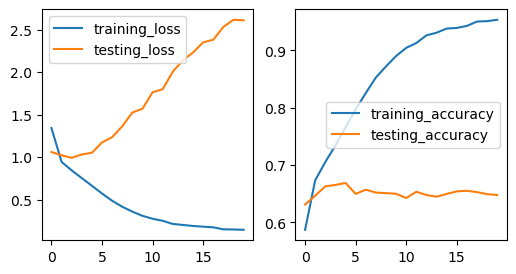

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.plot(results1.history["loss"], label="training_loss")
ax1.plot(results1.history["val_loss"], label="testing_loss")

ax2.plot(results1.history["accuracy"], label="training_accuracy")
ax2.plot(results1.history["val_accuracy"], label="testing_accuracy")

ax1.legend()
ax2.legend()

## BloodMnist dataset

In [27]:
data_train = dt.BloodMNIST("train", download=True)

Using downloaded and verified file: /data/home/karmpatel/.medmnist/bloodmnist.npz


In [28]:
data_test = dt.BloodMNIST("test", download=True)

Using downloaded and verified file: /data/home/karmpatel/.medmnist/bloodmnist.npz


In [29]:
X_train, X_test = data_train.imgs, data_test.imgs
X_train.shape, X_test.shape

((11959, 28, 28, 3), (3421, 28, 28, 3))

In [30]:
y_train, y_test = data_train.labels, data_test.labels
y_train.shape, y_test.shape

((11959, 1), (3421, 1))

In [31]:
# preprocess data
n_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
X_train.shape, y_train.shape, y_test.shape

((11959, 28, 28, 3), (11959, 8), (3421, 8))

In [32]:
X_train = tf.keras.applications.vgg16.preprocess_input(X_train)
X_test = tf.keras.applications.vgg16.preprocess_input(X_test)

In [33]:
vgg_model = VGG16(weights="imagenet", input_shape=(32, 32, 3), include_top=False)
vgg_model.trainable = False # freeze

transfer_model2 = keras.Sequential()
transfer_model2.add(Resizing(32, 32))
transfer_model2.add(vgg_model)
transfer_model2.add(Flatten())
transfer_model2.add(Dense(512, activation="relu"))
# transfer_model2.add(Dropout(0.5))
transfer_model2.add(Dense(256, activation="relu"))
transfer_model2.add(Dense(n_classes, activation="softmax"))

transfer_model2.build((None,None,None, 3))
transfer_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 2056      
Total params: 15,110,728
Trainable params: 396,040
Non-trainable params: 14,714,688
____________________________________

In [34]:
transfer_model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.002),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [35]:
epochs = 30
results2 = transfer_model2.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/30
374/374 [==============================] - 4s 8ms/step - loss: 2.9160 - accuracy: 0.6546 - val_loss: 0.5410 - val_accuracy: 0.8077
Epoch 2/30
374/374 [==============================] - 3s 7ms/step - loss: 0.4742 - accuracy: 0.8286 - val_loss: 0.5014 - val_accuracy: 0.8158
Epoch 3/30
374/374 [==============================] - 2s 6ms/step - loss: 0.4355 - accuracy: 0.8356 - val_loss: 0.5245 - val_accuracy: 0.8004
Epoch 4/30
374/374 [==============================] - 3s 7ms/step - loss: 0.3947 - accuracy: 0.8557 - val_loss: 0.4644 - val_accuracy: 0.8328
Epoch 5/30
374/374 [==============================] - 3s 7ms/step - loss: 0.3736 - accuracy: 0.8605 - val_loss: 0.4515 - val_accuracy: 0.8375
Epoch 6/30
374/374 [==============================] - 2s 7ms/step - loss: 0.3636 - accuracy: 0.8661 - val_loss: 0.4522 - val_accuracy: 0.8325
Epoch 7/30
374/374 [==============================] - 2s 7ms/step - loss: 0.3315 - accuracy: 0.8782 - val_loss: 0.4194 - val_accuracy: 0.8471
Epoch 

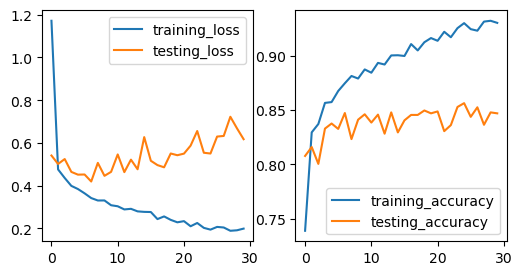

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.plot(results2.history["loss"], label="training_loss")
ax1.plot(results2.history["val_loss"], label="testing_loss")

ax2.plot(results2.history["accuracy"], label="training_accuracy")
ax2.plot(results2.history["val_accuracy"], label="testing_accuracy")

ax1.legend()
ax2.legend()

In [38]:
transfer_model2.evaluate(X_test, y_test)

107/107 [==============================] - 1s 6ms/step - loss: 0.6173 - accuracy: 0.8468


[0.6173045635223389, 0.8468284010887146]